#Installs, Imports, Google Drive, Global Variables

In [ ]:
!pip install transformers
!pip install faiss-gpu
#!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 99.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.5 MB/s eta 0:00:00


In [ ]:
# Modeling and data
#from efficientnet.tfkeras import EfficientNetB7
import torch
import tensorflow as tf
from transformers import AutoImageProcessor, TFViTModel, DetrImageProcessor, DetrForObjectDetection

# Google cloud storage
from google.cloud import storage

# File & system tools
import os
import shutil
import io
import time
import json

# Data manipulation
import pandas as pd
import numpy as np

# Image & plotting
import matplotlib.pyplot as plt
from PIL import Image

# FAISS
import faiss

ModuleNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Global Variables
# location of service account json
#service_account_location = "/content/drive/MyDrive/secrets/data-service-account.json"

# Location used to save and read tf_records
#tfrecords_output_dir = '/content/drive/MyDrive/austin_tfrecords'

# Used to create folders for embeddings
#model_name = "google/vit-huge-patch14-224-in21k"

# Location where embeddings are saved
#embeddings_dir = f"/content/drive/MyDrive/embeddings/{model_name}"

# Image size
#image_width = 224
#image_height = 224
#num_channels = 3

EMBEDDING_LENGTH = 1280
d = EMBEDDING_LENGTH

# GCP Authentication

In [ ]:
# Use to authenticate to GCP. Assumes data-service-account.json is in a secrets folder
# at location provided in global variables
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = service_account_location
!gcloud auth activate-service-account --key-file $GOOGLE_APPLICATION_CREDENTIALS

Activated service account credentials for: [data-service-account@spotted-399806.iam.gserviceaccount.com]


# Crop Image With Bounding Boxes

In [ ]:
# you can specify the revision tag if you don't want the timm dependency
detr_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

(…)resolve/no_timm/preprocessor_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

(…)tr-resnet-50/resolve/no_timm/config.json:   0%|          | 0.00/6.60k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

In [ ]:
detr_model.save_pretrained("/content/drive/MyDrive/detr_model")

In [ ]:
detr_processor.save_pretrained("/content/drive/MyDrive/detr_model")

['/content/drive/MyDrive/detr_model/preprocessor_config.json']

In [ ]:
detr_processor = DetrImageProcessor.from_pretrained("/content/drive/MyDrive/detr_model")

In [ ]:
detr_model = DetrForObjectDetection.from_pretrained("/content/drive/MyDrive/detr_model")

In [ ]:
# you can specify the revision tag if you don't want the timm dependency
detr_model_path = "/content/drive/MyDrive/huggingface/models/facebook/detr-resnet-50"

detr_processor = DetrImageProcessor.from_pretrained(detr_model_path)
detr_model = DetrForObjectDetection.from_pretrained(detr_model_path)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at /content/drive/MyDrive/huggingface/models/facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
chi = ["/content/drive/MyDrive/Images/n02085620-Chihuahua/n02085620_10074.jpg",
     "/content/drive/MyDrive/Images/n02085620-Chihuahua/n02085620_10131.jpg",
      "/content/drive/MyDrive/Images/n02085620-Chihuahua/n02085620_10621.jpg",
       "/content/drive/MyDrive/Images/n02085620-Chihuahua/n02085620_1073.jpg"]

shi = ["/content/drive/MyDrive/Images/n02086240-Shih-Tzu/n02086240_1011.jpg",
       "/content/drive/MyDrive/Images/n02086240-Shih-Tzu/n02086240_1016.jpg",
       "/content/drive/MyDrive/Images/n02086240-Shih-Tzu/n02086240_1059.jpg",
       "/content/drive/MyDrive/Images/n02086240-Shih-Tzu/n02086240_1078.jpg"]

In [ ]:
image = Image.open(shi[3])
detr_inputs = detr_processor(images=image, return_tensors="pt")
detr_outputs = detr_model(**detr_inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = detr_processor.post_process_object_detection(detr_outputs, target_sizes=target_sizes, threshold=0.9)[0]

bounding_boxes = []
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
  if detr_model.config.id2label[label.item()] == "dog":
                           box = [round(i, 2) for i in box.tolist()]
                           bounding_boxes.append((box[0], box[1], box[2], box[3]))
                           print(f"Detected {detr_model.config.id2label[label.item()]} with confidence " f"{round(score.item(), 3)} at location {box}")

Detected dog with confidence 0.999 at location [82.86, 145.72, 271.63, 449.36]


In [ ]:
bounding_boxes

[(82.86, 145.72, 271.63, 449.36)]

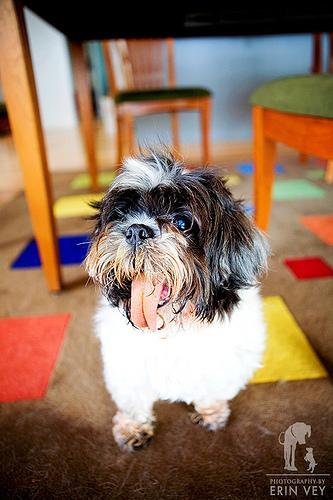

In [ ]:
image

In [ ]:
bounded_image = image.crop(bounding_boxes[0])

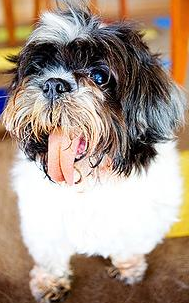

In [ ]:
bounded_image

# Generate Embedding from Cropped Image

### WARNING

In [ ]:
vit_processor = AutoImageProcessor.from_pretrained("/content/drive/MyDrive/huggingface/models/google/vit-huge-patch14-224-in21k")
vit_model = TFViTModel.from_pretrained("/content/drive/MyDrive/huggingface/models/google/vit-huge-patch14-224-in21k")

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at /content/drive/MyDrive/huggingface/models/google/vit-huge-patch14-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [ ]:
#feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-huge-patch14-224-in21k')
#model = ViTModel.from_pretrained('google/vit-huge-patch14-224-in21k')
#inputs = feature_extractor(images=cropped_image, return_tensors="pt")
#outputs = model(**inputs)

vit_inputs = vit_processor(images=bounded_image, return_tensors="tf")
vit_outputs = vit_model(**vit_inputs)

In [ ]:
numpy_embedding = vit_outputs.pooler_output.numpy()

NameError: ignored

# FAISS

#LOST DOGS

---





In [ ]:
lost_index_path = "/content/drive/MyDrive/persistent_folder/faiss/lost_index"
try:
  lost_index = faiss.read_index(lost_index_path)
except:
  lost_index = faiss.IndexFlatIP(d)

NameError: ignored

Normalize Embedding to be able to use cosine similarity

If Image is of a lost dog, we will add to the daframe and index of lost dogs query any found dogs against it.

If Image is of a found dog, we will add to the daframe and index of found dogs and query any found dogs against it.

In [ ]:
faiss.normalize_L2(numpy_embedding)
lost_index.add(numpy_embedding)
faiss.write_index(lost_index, lost_index_path)

NameError: ignored

In [ ]:
lost_image_number = lost_index.ntotal - 1

lost_original_path = f"/content/drive/MyDrive/persistent_folder/spotted-images/lost/original/original_lost_{lost_image_number}.jpg"
lost_cropped_path = f"/content/drive/MyDrive/persistent_folder/spotted-images/lost/cropped/cropped_lost_{lost_image_number}.jpg"
lost_df_path = '/content/drive/MyDrive/persistent_folder/spotted-dataframes/lost_df.csv'

image.save(lost_original_path)
bounded_image.save(lost_cropped_path)

try:
  lost_df = pd.read_csv(lost_df_path)
except:
  lost_df = pd.DataFrame(columns=["Owner Email", "Owner Phone Number", "Original Image Path", "Cropped Image Path"])

lost_update = {"Owner Email" : "TBD", "Owner Phone Number" : "TBD",
               "Original Image Path" : lost_original_path, "Cropped Image Path" : lost_cropped_path  }

lost_df = lost_df.append(lost_update, ignore_index=True)

lost_df.to_csv(lost_df_path, index=False)


<ipython-input-33-289b19afc904>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lost_df = lost_df.append(lost_update, ignore_index=True)


#Found Dogs

In [ ]:
found_index_path = "/content/drive/MyDrive/persistent_folder/faiss/found_index"
try:
  found_index = faiss.read_index(found_index_path)
except:
  found_index = faiss.IndexFlatIP(d)


In [ ]:
faiss.normalize_L2(numpy_embedding)
found_index.add(numpy_embedding)
faiss.write_index(found_index, found_index_path)

In [ ]:
found_image_number = found_index.ntotal - 1

found_original_path = f"/content/drive/MyDrive/persistent_folder/spotted-images/found/original/original_found_{found_image_number}.jpg"
found_cropped_path = f"/content/drive/MyDrive/persistent_folder/spotted-images/found/cropped/cropped_found_{found_image_number}.jpg"
found_df_path = '/content/drive/MyDrive/persistent_folder/spotted-dataframes/found_df.csv'

image.save(found_original_path)
bounded_image.save(found_cropped_path)

try:
  found_df = pd.read_csv(found_df_path)
except:
  found_df = pd.DataFrame(columns=["Spotter Email", "Spotter Phone Number", "Original Image Path", "Cropped Image Path"])

found_update = {"Spotter Email" : "TBD", "Spotter Phone Number" : "TBD",
               "Original Image Path" : found_original_path, "Cropped Image Path" : found_cropped_path  }

found_df = found_df.append(found_update, ignore_index=True)

found_df.to_csv(found_df_path, index=False)

<ipython-input-67-f19b6720e3a3>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  found_df = found_df.append(found_update, ignore_index=True)


#Experiments


In [ ]:
lost_index = faiss.read_index(lost_index_path)
found_index = faiss.read_index(found_index_path)

In [ ]:
k = 4
similarity, similarity_index = lost_index.search(numpy_embedding, k)

In [ ]:
similarity[0]

array([0.88669086, 0.78589666, 0.5168992 , 0.50808084], dtype=float32)

In [ ]:
similarity_index

array([[2, 3, 1, 0]])

In [ ]:
above_threshold = similarity_index[similarity>.7]

In [ ]:
above_threshold

array([2, 3])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

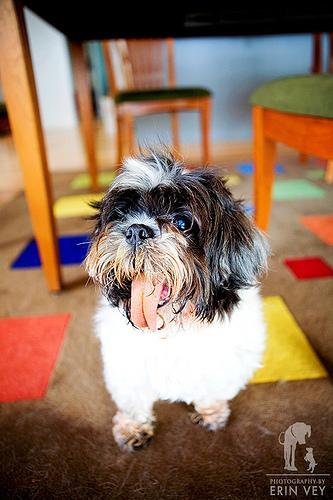

In [ ]:
image

In [ ]:
for i, index in enumerate(above_threshold):
  print(f"Similarity Value: {similarity[0][i]}")
  img = mpimg.imread(lost_df.iloc[index]['Original Image Path'])
  plt.imshow(img)
  plt.axis('off')
  plt.show()
  print(f"{found_df.iloc[index]['Original Image Path']}")

NameError: ignored